データサイエンス グループワーク

使用データセット："Bike Sharing Demand"

データセット概要：
- ワシントンDCのレンタルバイク(自転車)の台数を予測する
- 2011年と2012年の各月1-20日のデータが学習データとして，21-末日がテストデータとして与えられる

**追記：プログラム作成にはGitHub Copilotを使用しています**

In [1]:
# !pip install japanize_matplotlib

In [2]:
%matplotlib inline
# ライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import japanize_matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb.set_config(verbosity=0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# 学習データの読み込み
train_data = pd.read_csv("train.csv") # ファイル名とパスは各自で変更してください
# train_data = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv") # kaggle用
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# テストデータの読み込み
test_data = pd.read_csv("test.csv") # ファイル名とパスは各自で変更してください
# test_data = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv") # kaggle用
test_data.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [5]:
# submission.csv作成用
test_datetime = test_data["datetime"]

##### データの観察

データにおける各項目の意味は以下の通りです。

- datetime: 日時(1時間ごと)
- season: 
    1. 春
    2. 夏
    3. 秋
    4. 冬
- holiday: その日が休日とみなされているかどうか
- workingday: その日が週末でも休日でもないかどうか
- weather: 
    1. 晴れ、少量の雲、一部曇り、一部曇り
    2. 霧 曇り、霧 切れ間のある雲、霧 少量の雲、霧
    3. 小雪、小雨 雷雨 散在する雲、小雨 散在する雲
    4. 大雨 氷のパレット 雷雨 霧、雪 霧
- temp: 摂氏温度(℃)
- atemp: 体感温度
- humidity: 湿度
- windspeed: 風速
- casual: 開始された非登録ユーザーのレンタル数
- registerd: レンタルを開始した登録ユーザーの数
- count: 総レンタル数

In [6]:
train_data.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
3750,2011-09-07 05:00:00,3,0,1,2,22.96,26.515,100,8.9981,1,15,16
394,2011-01-17 22:00:00,1,1,0,3,5.74,6.060,93,16.9979,0,13,13
3529,2011-08-16 23:00:00,3,0,1,1,27.06,31.060,65,8.9981,20,57,77
8378,2012-07-10 11:00:00,3,0,1,1,32.80,36.365,46,12.9980,92,157,249
2041,2011-05-11 23:00:00,2,0,1,1,18.86,22.725,88,16.9979,12,69,81


In [7]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


**データの準備**

In [8]:
# まとめて処理をするためにリストに格納
both_data = [train_data, test_data]

In [9]:
for dataset in both_data:
    # "weather"と"season"をダミー変数へ変換
    dataset["weather"] = dataset["weather"].replace({1: "clear", 2: "cloudy", 3: "rainy", 4: "stormy"})
    dataset["season"] = dataset["season"].replace({1: "spring", 2: "summer", 3: "autumn", 4: "winter"})

    # ダミー変数化して一時的なデータフレームを作成
    dummies = pd.get_dummies(dataset, columns=["weather", "season"], dtype="int")

    for column in dummies.columns:
        if column not in dataset.columns:
            dataset[column] = dummies[column]

    # datetime型に変換して月，時間，曜日を取得(0:月曜, 1:火曜, ..., 6:日曜)
    dataset["datetime"] = pd.to_datetime(dataset["datetime"])
    dataset["month"] = dataset["datetime"].dt.month
    dataset["hour"] = dataset["datetime"].dt.hour
    dataset["dayofweek"] = dataset["datetime"].dt.dayofweek
    # dataset.drop("datetime", axis=1, inplace=True)

    # 前日との差分を取る
    dataset["temp_lag_yesterday"] = dataset["temp"].shift(1)
    dataset["atemp_lag_yesterday"] = dataset["atemp"].shift(1)
    dataset["humidity_lag_yesterday"] = dataset["humidity"].shift(1)
    dataset["windspeed_lag_yesterday"] = dataset["windspeed"].shift(1)

    # 1週間前との差分を取る
    dataset["temp_lag_lastweek"] = dataset["temp"].shift(7)
    dataset["atemp_lag_lastweek"] = dataset["atemp"].shift(7)
    dataset["humidity_lag_lastweek"] = dataset["humidity"].shift(7)
    dataset["windspeed_lag_lastweek"] = dataset["windspeed"].shift(7)

In [10]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek
0,2011-01-01 00:00:00,spring,0,0,clear,9.84,14.395,81,0.0,3,13,16,1,0,0,0,0,1,0,0,1,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,spring,0,0,clear,9.02,13.635,80,0.0,8,32,40,1,0,0,0,0,1,0,0,1,1,5,9.84,14.395,81.0,0.0,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,spring,0,0,clear,9.02,13.635,80,0.0,5,27,32,1,0,0,0,0,1,0,0,1,2,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,spring,0,0,clear,9.84,14.395,75,0.0,3,10,13,1,0,0,0,0,1,0,0,1,3,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,spring,0,0,clear,9.84,14.395,75,0.0,0,1,1,1,0,0,0,0,1,0,0,1,4,5,9.84,14.395,75.0,0.0,NaN,NaN,NaN,NaN


/tmp/ipykernel_44797/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7ff508315750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
/tmp/ipykernel_44797/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7ff508315750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
/tmp/ipykernel_44797/165542432.py:4: FutureWarning: The provided callable <function sum at 0x7ff508315750> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current 

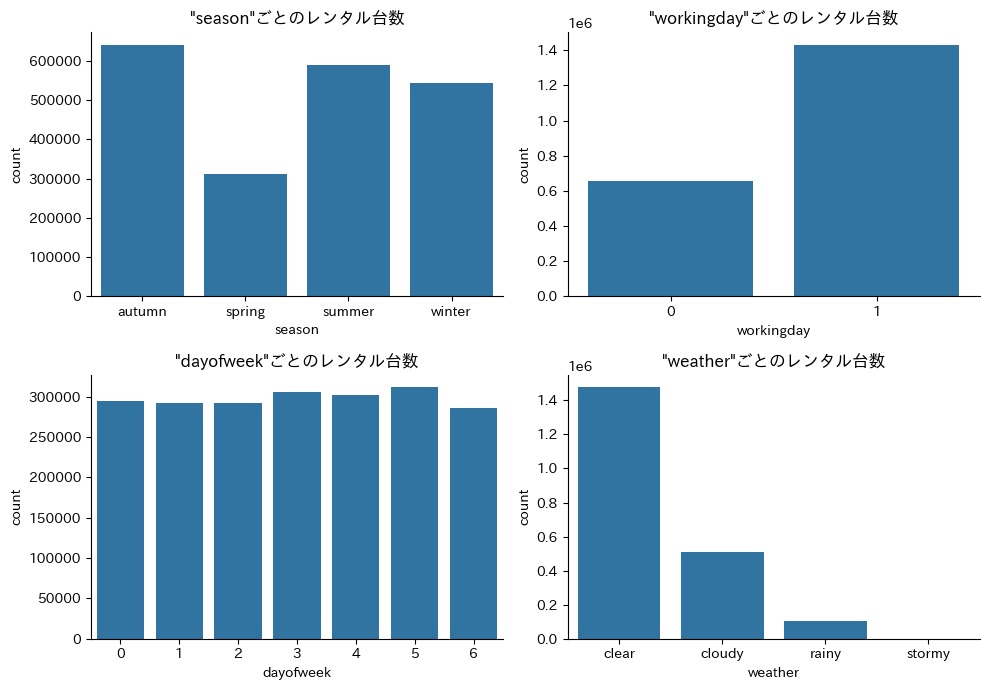

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i, column_name in enumerate(['season', 'workingday', 'dayofweek', 'weather']):
    rentals = train_data.pivot_table(values='count', index=column_name, aggfunc=np.sum).reset_index()
    rentals['percentage'] = np.round(100 * rentals['count'] / np.sum(rentals['count']))

    row, col = divmod(i, 2)
    barplot = sns.barplot(data=rentals, x=column_name, y='count', ax=ax[row, col])

    ax[row, col].set_title(f"\"{column_name}\"ごとのレンタル台数")
    sns.despine()

plt.tight_layout()
plt.show()

**結果から示唆されること**
- 秋に最もレンタル台数が多く，春に少ない
- workingday(平日)のほうが台数が多い
    - 曜日ごとでみると，各曜日にそれほど大きな差はないため，平日:休日が5:2の割合となっている可能性が考えられる
- 晴れの場合が最も台数が多く，天気が悪くなるほど台数は減少傾向

##### 温度に関するデータを確認

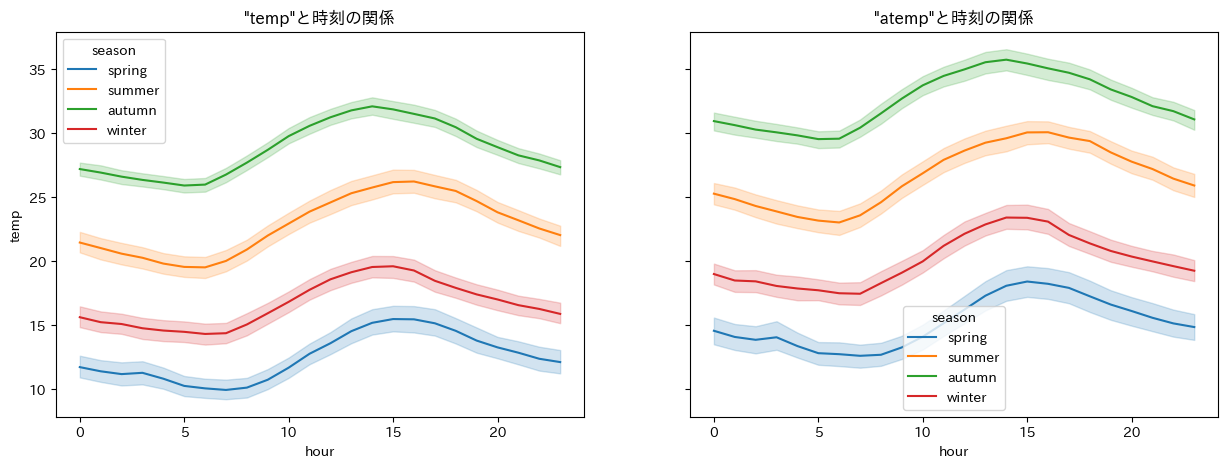

In [12]:
# 温度，体感温度と時刻の関係をグラフ化
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(15, 5))
for i, column_name in enumerate(["temp", "atemp"]):
    sns.lineplot(data=train_data, x='hour', y=column_name, hue='season', ax=ax[i])
    ax[i].set_title(f"\"{column_name}\"と時刻の関係")
    ax[i].set_yticks(np.arange(10, 40, 5))
plt.show()


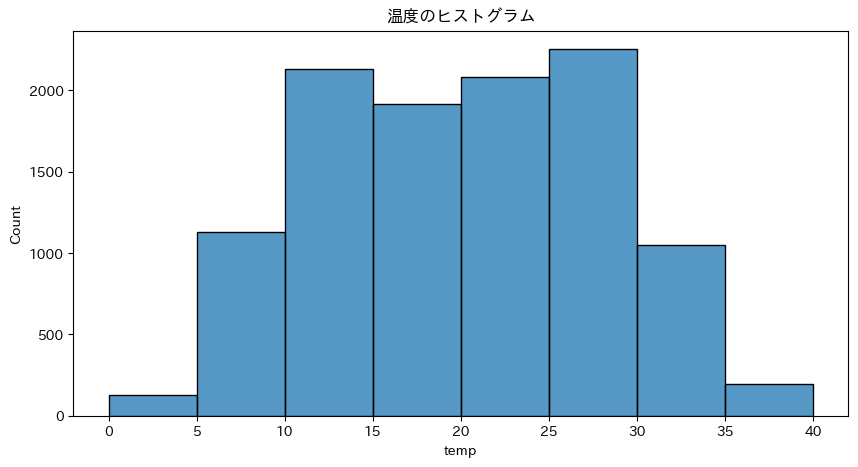

In [13]:
# ヒストグラムの表示
plt.figure(figsize=(10, 5))
sns.histplot(train_data["temp"], bins=range(0, 41, 5))
plt.title("温度のヒストグラム")
plt.show()

**ここからわかること**
- 体感温度は気温から数℃~5℃程度高くなる傾向がある
- 気温の推移はどの季節においても概ね同じであり，異なるのは温度のみ
- 温度のヒストグラムにおいて，10-15℃と25-30℃が高くなっているのは，夏と冬の気温の大部分がこの部分に属するため

**体感温度と気温の差に関する特徴量を作成**

体感温度と気温の差が高い場合は，天候が悪いケースが想定される

In [14]:
# 体感温度と気温の差に関する特徴量を作成
for dataset in both_data:
    dataset["temp_diff"] = dataset["temp"] - dataset["atemp"]

##### データの分布の確認

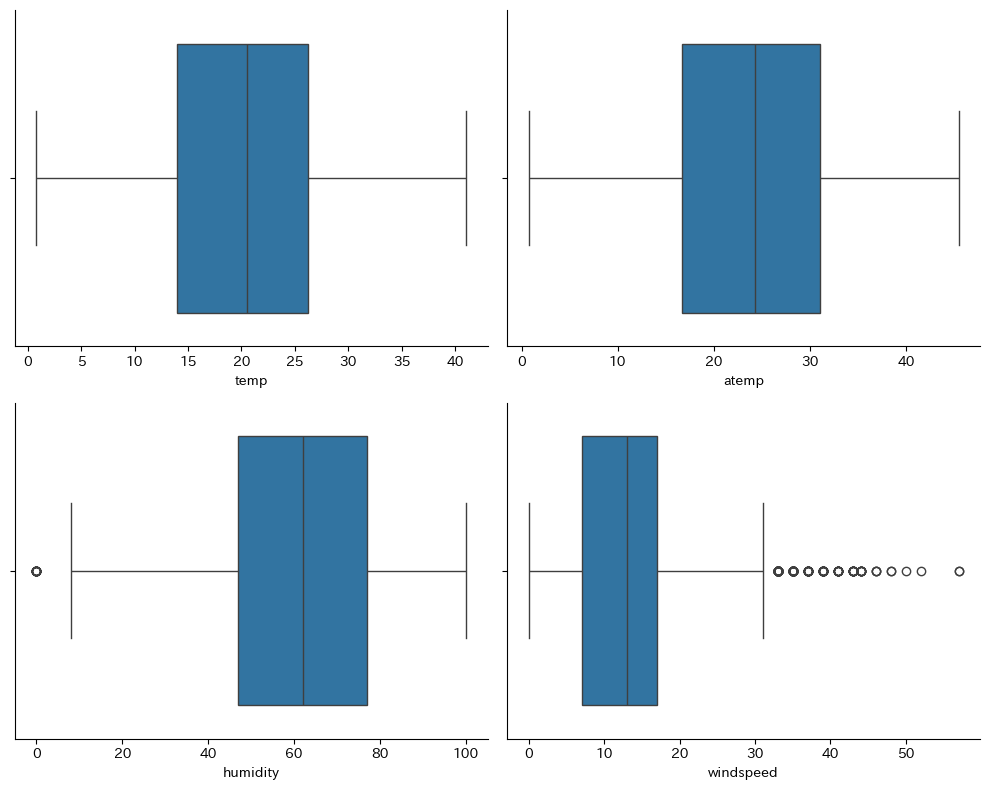

In [15]:
# データ分布を箱ひげ図で確認
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))

for i, column in enumerate(['temp', 'atemp', 'humidity', 'windspeed']):

    row, col = divmod(i, 2)
    sns.boxplot(data = train_data, x = column, ax = ax[row, col])
    sns.despine()

plt.tight_layout()
plt.show()

**結果からわかること**
- "windspeed"には大量の外れ値がある

##### 日中時間(太陽が出ている時間)の追加

地軸の傾きと緯度から，日中時間を算出する



In [16]:
def hours_of_daylight(date, axis=23.44, latitude=38.9041):
    # 日付をpd.Timestamp形式に変換
    date = pd.to_datetime(date)

    # 基準日（2000年12月21日）からの経過日数を計算
    if isinstance(date, pd.Series):
        days = (date - pd.Timestamp(2011, 12, 21)).dt.days
    else:
        days = (date - pd.Timestamp(2011, 12, 21)).days

    # 昼間の時間を計算するための中間変数mを計算
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25))

    # mの値を0から2の範囲に制限
    m = np.clip(m, 0, 2)

    # 昼間の時間（時間）を計算
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [17]:
for dataset in both_data:
    # 日中時間を追加
    dataset["daylight_hours"] = hours_of_daylight(dataset["datetime"])


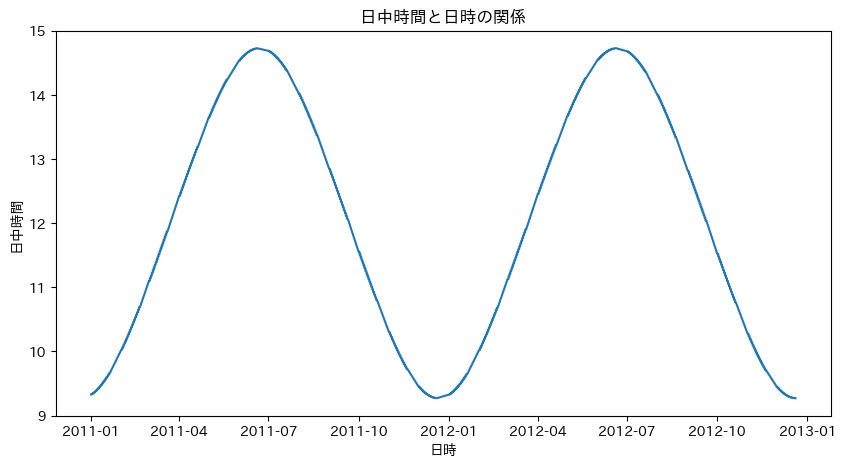

In [18]:
#日中時間と日時の関係を折れ線グラフで可視化
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
x = train_data["datetime"]
y = train_data["daylight_hours"]
ax.plot(x, y)
ax.set_title("日中時間と日時の関係")
ax.set_xlabel("日時")
ax.set_ylabel("日中時間")
plt.show()

##### データの前処理

**外れ値を除外する**

箱ひげ図でも確認したが，他の変数についても再度確認する

In [19]:
train_data.describe()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek,temp_diff,daylight_hours
count,10886,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10885.000000,10885.000000,10885.000000,10885.000000,10879.000000,10879.000000,10879.000000,10879.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,0.660665,0.260334,0.078909,0.000092,0.251056,0.246739,0.251056,0.251148,6.521495,11.541613,3.013963,20.231513,23.655726,61.886082,12.799745,20.234380,23.658606,61.889972,12.796508,-3.424224,12.003257
min,2011-01-01 00:00:00,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,-8.045000,9.269943
25%,2011-07-02 07:15:00,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,47.000000,7.001500,13.940000,16.665000,47.000000,7.001500,-4.055000,10.158801
50%,2012-01-01 20:30:00,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,12.000000,3.000000,20.500000,24.240000,62.000000,12.998000,20.500000,24.240000,62.000000,12.998000,-3.680000,12.040675
75%,2012-07-01 12:45:00,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,10.000000,18.000000,5.000000,26.240000,31.060000,77.000000,16.997900,26.240000,31.060000,77.000000,16.997900,-2.745000,13.854127
max,2012-12-19 23:00:00,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,23.000000,6.000000,41.000000,45.455000,100.000000,56.996900,41.000000,45.455000,100.000000,56.996900,23.140000,14.729547
std,NaN,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.473505,0.438837,0.269609,0.009584,0.433641,0.431133,0.433641,0.433694,3.444373,6.915838,2.004585,7.791650,8.474725,19.245877,8.164831,7.792812,8.476089,19.250111,8.164099,1.566612,1.889470


- 先ほど確認したとおり，"windspeed"は外れ値を持っている可能性が高い
- "casual", "registered"についても，外れ値を持っている可能性が高い
- それ以外の変数については，外れ値となるような値はないものとして考える("count", はターゲットのため考えない)

In [20]:
# 外れ値を除外する関数
def remove_outliers_using_iqr(df, columns):
    df = df.copy()  # 元のデータフレームを変更しないようにコピーを作成

    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        outlier_min = q1 - 1.5 * iqr
        outlier_max = q3 + 1.5 * iqr
        df = df[(df[column] >= outlier_min) & (df[column] <= outlier_max)]

    return df

# "windspeed"，"casual"，"registered"について，外れ値を除外
outlier_columns = ["windspeed", "casual", "registered"]
train_data = remove_outliers_using_iqr(train_data, outlier_columns)

In [21]:
# 処理結果の確認
train_data.describe()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek,temp_diff,daylight_hours
count,9399,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.00000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9399.000000,9398.000000,9398.000000,9398.000000,9398.000000,9392.000000,9392.000000,9392.000000,9392.000000,9399.000000,9399.000000
mean,2011-12-16 02:51:21.391637248,0.026705,0.710076,19.510224,22.903316,63.692733,12.120233,23.539419,120.732099,144.271518,0.645813,0.270029,0.084051,0.000106,0.23811,0.262581,0.239919,0.259389,6.484839,11.098521,2.934142,19.515529,22.906888,63.615344,12.272600,19.925948,23.324174,61.619996,12.866462,-3.393092,11.906099
min,2011-01-01 00:00:00,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,-8.045000,9.269943
25%,2011-06-13 19:30:00,0.000000,0.000000,13.120000,15.910000,49.000000,7.001500,3.000000,28.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.000000,5.000000,1.000000,13.120000,15.910000,49.000000,7.001500,13.940000,16.476250,46.000000,7.001500,-4.055000,10.090595
50%,2011-12-09 23:00:00,0.000000,1.000000,18.860000,22.725000,65.000000,11.001400,12.000000,99.000000,119.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,6.000000,11.000000,3.000000,18.860000,22.725000,64.000000,11.001400,19.680000,23.485000,61.000000,12.998000,-3.680000,11.683193
75%,2012-06-12 09:30:00,0.000000,1.000000,26.240000,30.305000,79.000000,16.997900,36.000000,183.000000,225.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,10.000000,18.000000,5.000000,26.035000,30.305000,79.000000,16.997900,26.240000,31.060000,77.000000,16.997900,-2.680000,13.793264
max,2012-12-19 23:00:00,1.000000,1.000000,41.000000,45.455000,100.000000,31.000900,116.000000,456.000000,563.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,12.000000,23.000000,6.000000,41.000000,45.455000,100.000000,56.996900,41.000000,45.455000,100.000000,56.996900,22.320000,14.729547
std,NaN,0.161228,0.453751,7.667198,8.346320,18.902227,7.441579,26.756632,106.528965,124.192392,0.478292,0.443998,0.277480,0.010315,0.42595,0.440060,0.427057,0.438323,3.527498,7.175236,1.976405,7.663899,8.354614,18.863135,7.755387,7.906332,8.593168,19.417880,8.129554,1.488531,1.898987


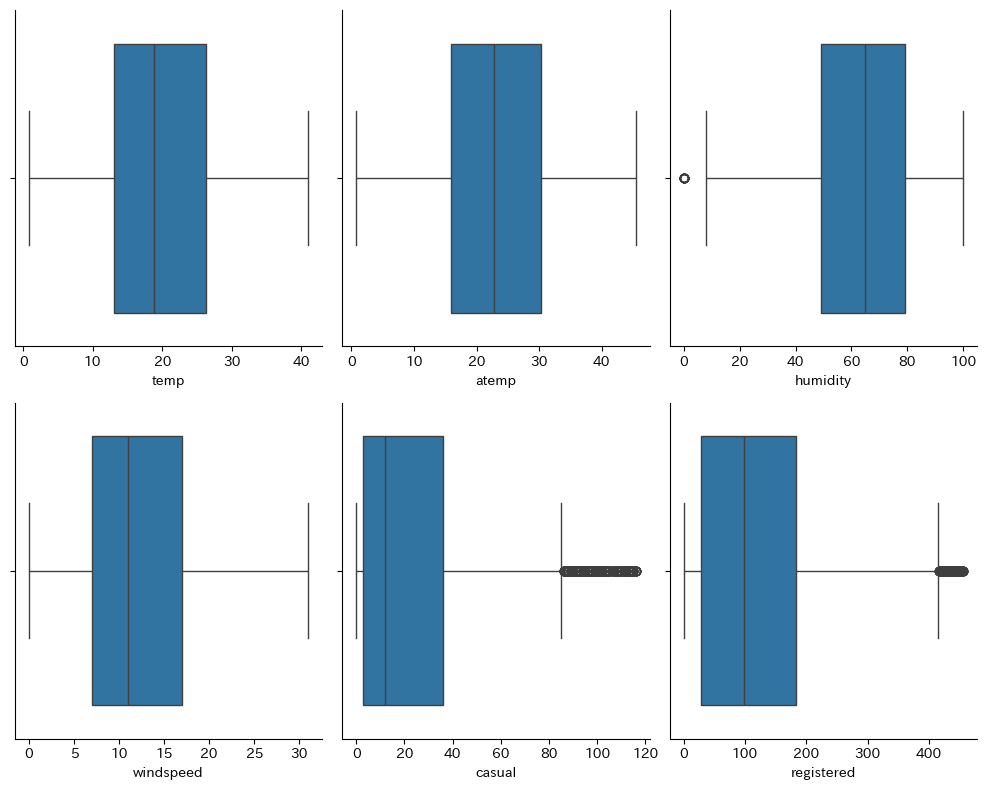

In [22]:
# データ分布を箱ひげ図で確認
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 8))

for i, column in enumerate(["temp", "atemp", "humidity", "windspeed", "casual", "registered"]):

    row, col = divmod(i, 3)
    sns.boxplot(data = train_data, x = column, ax = ax[row, col])
    sns.despine()

plt.tight_layout()
plt.show()

**相関係数の確認**

In [23]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek,temp_diff,daylight_hours
0,2011-01-01 00:00:00,spring,0,0,clear,9.84,14.395,81,0.0,3,13,16,1,0,0,0,0,1,0,0,1,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.555,9.328632
1,2011-01-01 01:00:00,spring,0,0,clear,9.02,13.635,80,0.0,8,32,40,1,0,0,0,0,1,0,0,1,1,5,9.84,14.395,81.0,0.0,NaN,NaN,NaN,NaN,-4.615,9.328632
2,2011-01-01 02:00:00,spring,0,0,clear,9.02,13.635,80,0.0,5,27,32,1,0,0,0,0,1,0,0,1,2,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN,-4.615,9.328632
3,2011-01-01 03:00:00,spring,0,0,clear,9.84,14.395,75,0.0,3,10,13,1,0,0,0,0,1,0,0,1,3,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN,-4.555,9.328632
4,2011-01-01 04:00:00,spring,0,0,clear,9.84,14.395,75,0.0,0,1,1,1,0,0,0,0,1,0,0,1,4,5,9.84,14.395,75.0,0.0,NaN,NaN,NaN,NaN,-4.555,9.328632


In [24]:
both_data = [train_data, test_data]

# ダミー変数があるので削除
for dataset in both_data:
    # オリジナルのデータフレームを更新
    dataset.drop(columns=["season", "weather"], inplace=True)

In [25]:
train_data.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek,temp_diff,daylight_hours
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,1,0,0,0,0,1,0,0,1,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.555,9.328632
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,1,0,0,0,0,1,0,0,1,1,5,9.84,14.395,81.0,0.0,NaN,NaN,NaN,NaN,-4.615,9.328632
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,1,0,0,0,0,1,0,0,1,2,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN,-4.615,9.328632
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,1,0,0,0,0,1,0,0,1,3,5,9.02,13.635,80.0,0.0,NaN,NaN,NaN,NaN,-4.555,9.328632
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,1,0,0,0,0,1,0,0,1,4,5,9.84,14.395,75.0,0.0,NaN,NaN,NaN,NaN,-4.555,9.328632


<Axes: >

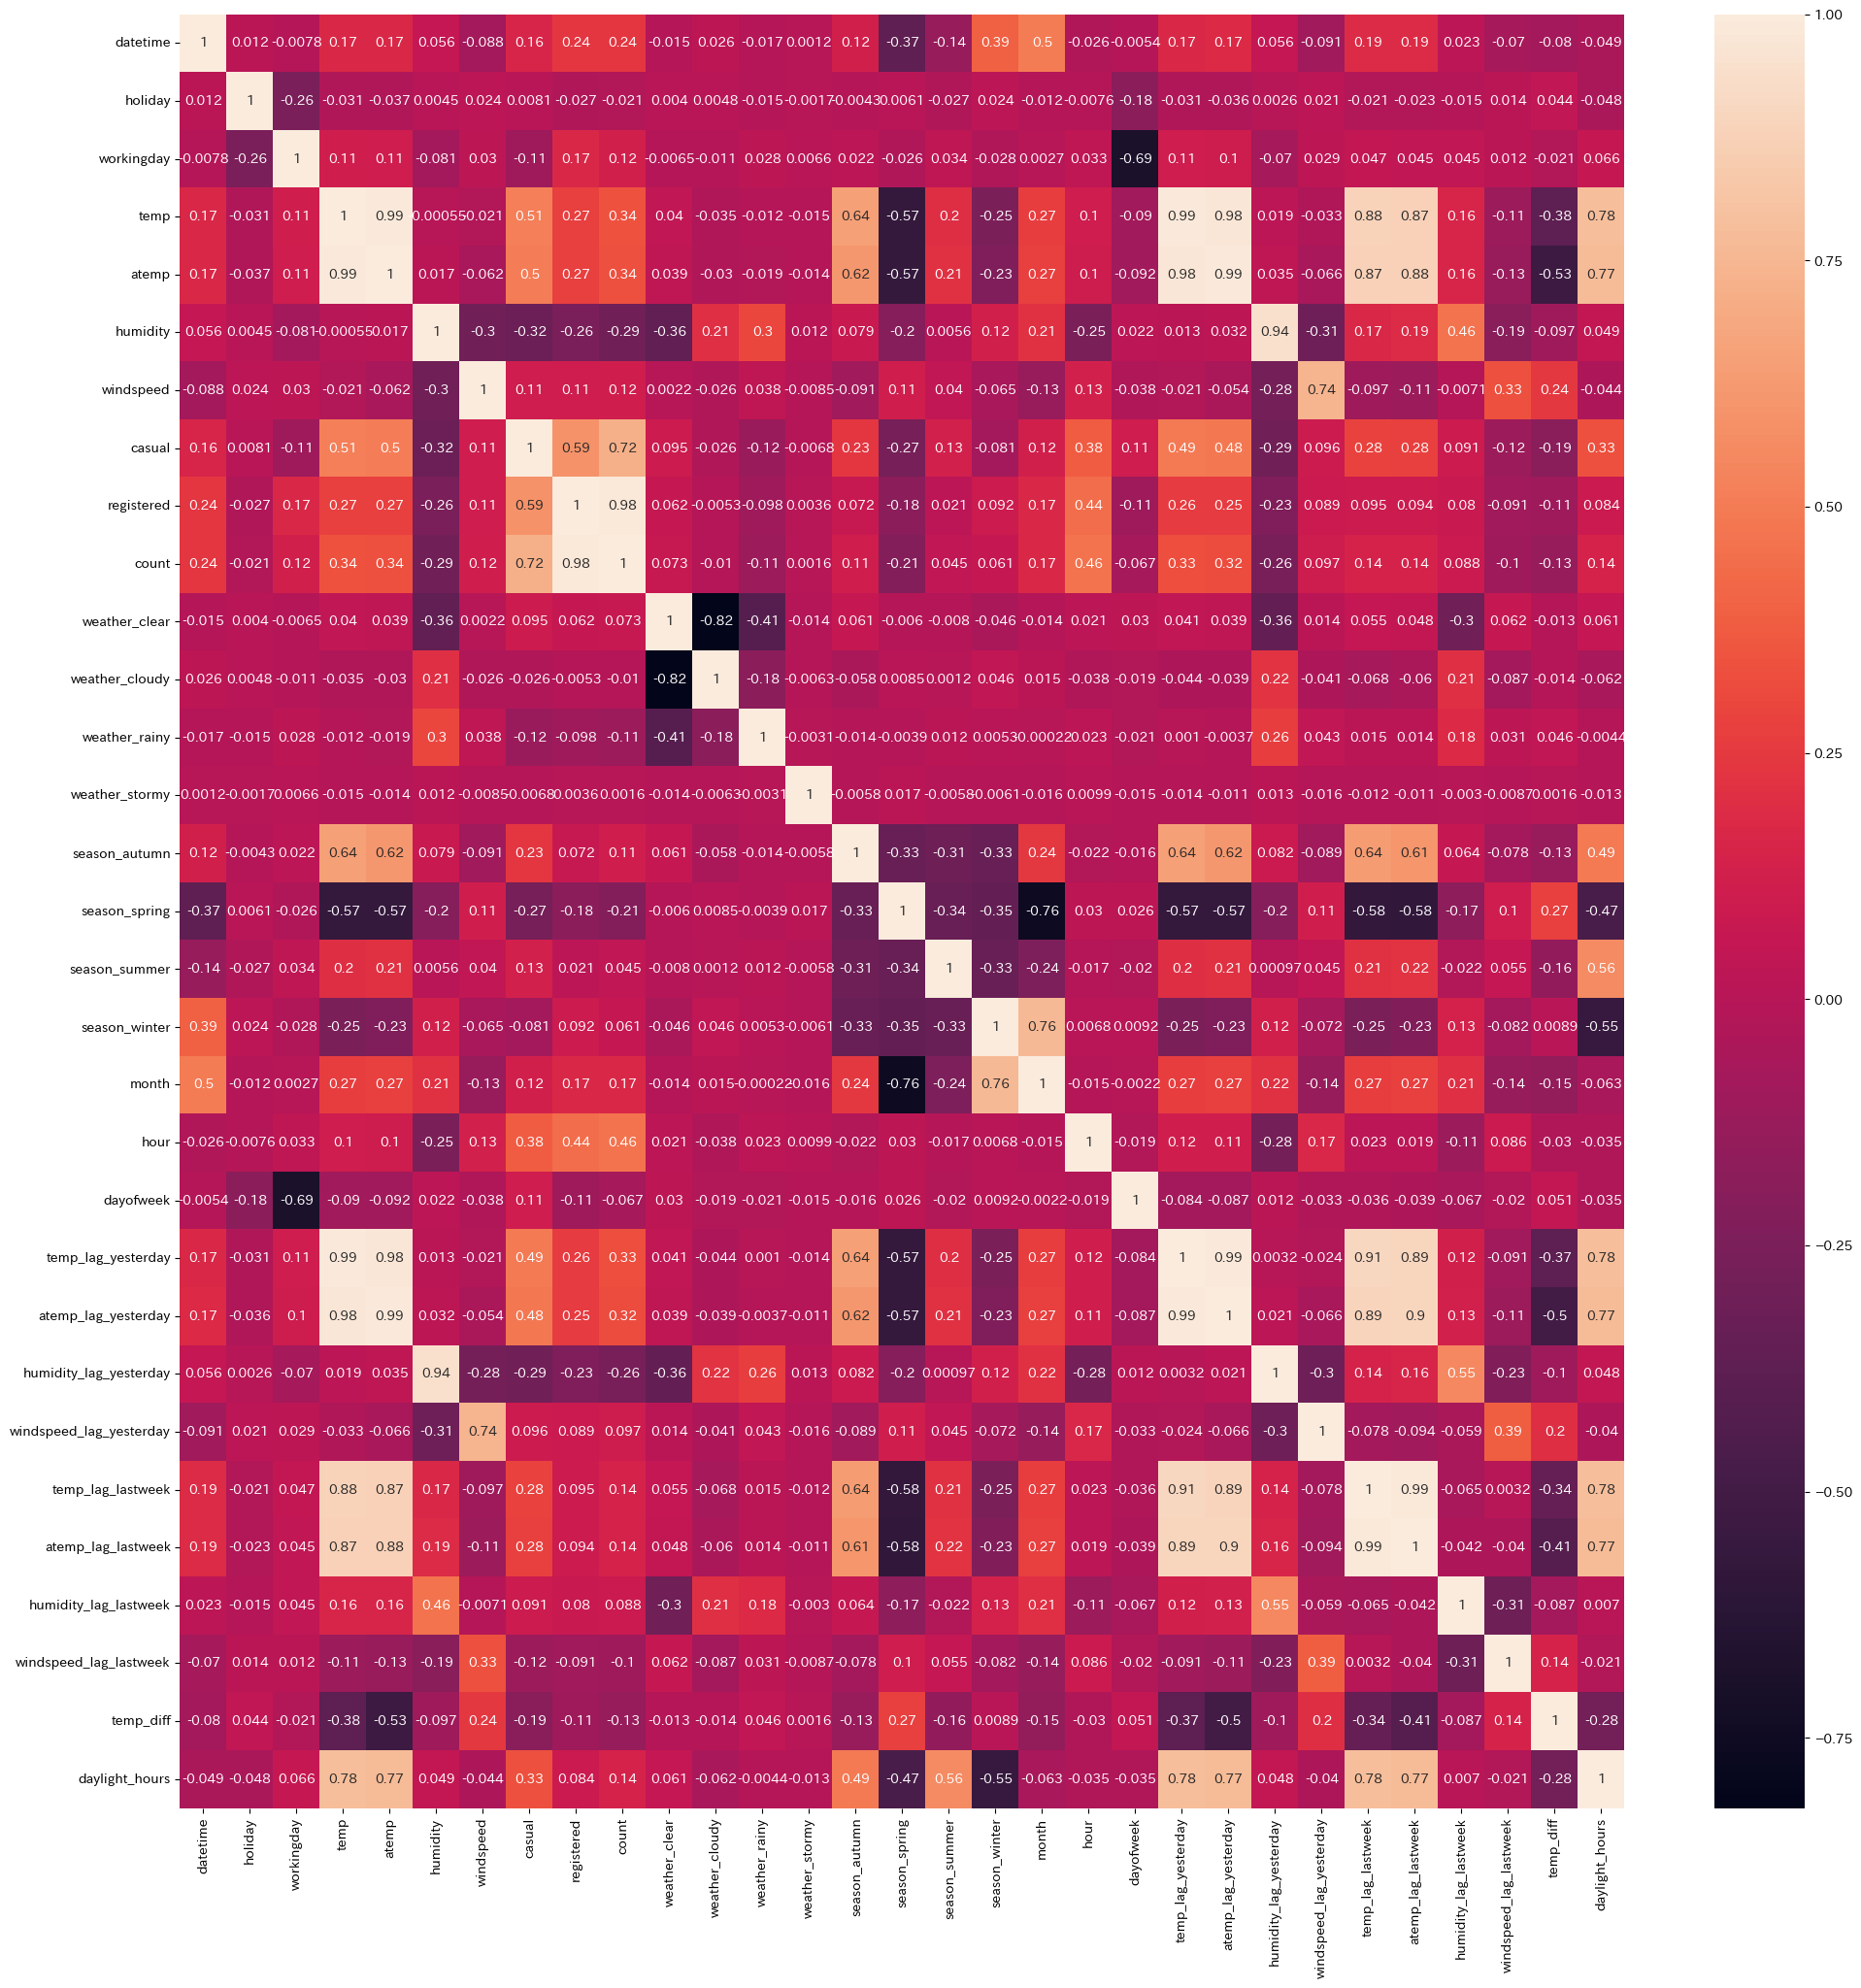

In [26]:
plt.figure(figsize = (24, 24))
sns.heatmap(train_data.corr(), annot = True) # ヒートマップの表示

In [27]:
# 相関係数が高い特徴量を値とともに順に表示
high_corr_casual = train_data.corr()["casual"].sort_values(ascending=False)
high_corr_registered = train_data.corr()["registered"].sort_values(ascending=False)

print("casualとの相関係数")
print(high_corr_casual)

print("\nregisteredとの相関係数")
print(high_corr_registered)

casualとの相関係数
casual                     1.000000
count                      0.720928
registered                 0.589297
temp                       0.510143
atemp                      0.503299
temp_lag_yesterday         0.492843
atemp_lag_yesterday        0.484421
hour                       0.377210
daylight_hours             0.333373
temp_lag_lastweek          0.281566
atemp_lag_lastweek         0.277759
season_autumn              0.233592
datetime                   0.157141
season_summer              0.125598
month                      0.122826
windspeed                  0.107534
dayofweek                  0.107116
windspeed_lag_yesterday    0.095579
weather_clear              0.094759
humidity_lag_lastweek      0.091009
holiday                    0.008130
weather_stormy            -0.006762
weather_cloudy            -0.026306
season_winter             -0.080730
workingday                -0.109116
windspeed_lag_lastweek    -0.116236
weather_rainy             -0.120991
temp_diff      

**相関係数からわかること**

- "casual"のレンタル数は，気温と体感温度，日中時間と高い相関がある(前日との差分も高い相関)
- "registered"のレンタル数は，時刻と高い相関がある -> 通勤など，日常的な利用
    - 気温と体感温度に対する相関は時刻ほどではないが若干高い

##### 学習・推論

**データの準備**

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9399 entries, 0 to 10885
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 9399 non-null   datetime64[ns]
 1   holiday                  9399 non-null   int64         
 2   workingday               9399 non-null   int64         
 3   temp                     9399 non-null   float64       
 4   atemp                    9399 non-null   float64       
 5   humidity                 9399 non-null   int64         
 6   windspeed                9399 non-null   float64       
 7   casual                   9399 non-null   int64         
 8   registered               9399 non-null   int64         
 9   count                    9399 non-null   int64         
 10  weather_clear            9399 non-null   int64         
 11  weather_cloudy           9399 non-null   int64         
 12  weather_rainy            9399 non-null

In [29]:
# train_dataを学習・検証・テストデータに分割(8:2)
X = train_data.drop(["datetime", "count", "casual", "registered"], axis=1)
y = train_data[["count", "casual", "registered"]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [30]:
y_train_count = y_train["count"]
y_valid_count = y_valid["count"]

y_train_casual = y_train["casual"]
y_valid_casual = y_valid["casual"]

y_train_registered = y_train["registered"]
y_valid_registered = y_valid["registered"]

**学習**

"casual"と"registered"のそれぞれについて予測し，合算して"count"を算出する

In [31]:
# "casual"の予測
# データをxgbのデータ構造に変換
dtrain_casual = xgb.DMatrix(X_train, label=y_train_casual)
dvalid_casual = xgb.DMatrix(X_valid, label=y_valid_casual)

# ハイパーパラメータの設定
params = {"objective": "reg:squarederror", "silent": 1, "random_state": 1234}
num_round = 150

# 学習
watchlist = [(dtrain_casual, "train"), (dvalid_casual, "eval")]
model_casual = xgb.train(params, dtrain_casual, num_round, evals=watchlist)

# 予測
pred_casual = model_casual.predict(dvalid_casual)

# 0以下の値を0に置換
pred_casual = np.where(pred_casual < 0, 0, pred_casual)

mse_casual = np.round(mean_squared_error(y_valid_casual, pred_casual), 2)
print(f"Mean Squared Error: {mse_casual}")

r2_score_casual = np.round(r2_score(y_valid_casual, pred_casual), 2)
print(f"R^2: {r2_score_casual}")

[0]	train-rmse:21.22848	eval-rmse:20.95428
[1]	train-rmse:17.70008	eval-rmse:17.61037
[2]	train-rmse:15.30291	eval-rmse:15.57013
[3]	train-rmse:13.66000	eval-rmse:14.06319
[4]	train-rmse:12.61253	eval-rmse:13.15872
[5]	train-rmse:11.83435	eval-rmse:12.60070
[6]	train-rmse:11.33275	eval-rmse:12.18054
[7]	train-rmse:11.01875	eval-rmse:11.94121
[8]	train-rmse:10.76167	eval-rmse:11.87627
[9]	train-rmse:10.56273	eval-rmse:11.73744
[10]	train-rmse:10.42758	eval-rmse:11.66215
[11]	train-rmse:10.31390	eval-rmse:11.61846
[12]	train-rmse:10.21492	eval-rmse:11.58685
[13]	train-rmse:10.12614	eval-rmse:11.53016
[14]	train-rmse:9.94739	eval-rmse:11.46039
[15]	train-rmse:9.86290	eval-rmse:11.41008
[16]	train-rmse:9.63982	eval-rmse:11.33258
[17]	train-rmse:9.46201	eval-rmse:11.26832
[18]	train-rmse:9.31680	eval-rmse:11.24789
[19]	train-rmse:9.25700	eval-rmse:11.22706
[20]	train-rmse:9.14612	eval-rmse:11.20511
[21]	train-rmse:9.07579	eval-rmse:11.16833
[22]	train-rmse:8.87847	eval-rmse:11.00637
[23]	tr

In [32]:
# "registered"の予測
# データをxgbのデータ構造に変換
dtrain_registered = xgb.DMatrix(X_train, label=y_train_registered)
dvalid_registered = xgb.DMatrix(X_valid, label=y_valid_registered)

# ハイパーパラメータの設定
params = {"objective": "reg:squarederror", "silent": 1, "random_state": 1234}
num_round = 150

# 学習
watchlist = [(dtrain_registered, "train"), (dvalid_registered, "eval")]
model_registered = xgb.train(params, dtrain_registered, num_round, evals=watchlist)

# 予測
pred_registered = model_registered.predict(dvalid_registered)

# 0以下の値を0に置換
pred_registered = np.where(pred_registered < 0, 0, pred_registered)

mse_registered = np.round(mean_squared_error(y_valid_registered, pred_registered), 2)
print(f"Mean Squared Error: {mse_registered}")

r2_score_registered = np.round(r2_score(y_valid_registered, pred_registered), 2)
print(f"R^2: {r2_score_registered}")

[0]	train-rmse:84.86496	eval-rmse:87.74579
[1]	train-rmse:72.24973	eval-rmse:75.19483
[2]	train-rmse:62.81658	eval-rmse:66.17110
[3]	train-rmse:57.08907	eval-rmse:60.87361
[4]	train-rmse:53.34912	eval-rmse:57.79241
[5]	train-rmse:49.75246	eval-rmse:54.52097
[6]	train-rmse:47.93061	eval-rmse:52.47028
[7]	train-rmse:45.41990	eval-rmse:50.31062
[8]	train-rmse:44.42986	eval-rmse:49.32281
[9]	train-rmse:43.31870	eval-rmse:48.80189
[10]	train-rmse:42.03134	eval-rmse:47.73810
[11]	train-rmse:41.53467	eval-rmse:47.43084
[12]	train-rmse:41.18438	eval-rmse:47.11622
[13]	train-rmse:40.50527	eval-rmse:46.59751
[14]	train-rmse:39.83408	eval-rmse:46.00384
[15]	train-rmse:39.18394	eval-rmse:45.67868
[16]	train-rmse:38.94868	eval-rmse:45.49697
[17]	train-rmse:38.22949	eval-rmse:45.38484
[18]	train-rmse:37.79085	eval-rmse:45.01868
[19]	train-rmse:36.92734	eval-rmse:44.64130
[20]	train-rmse:36.42846	eval-rmse:44.29773
[21]	train-rmse:36.14674	eval-rmse:44.11884
[22]	train-rmse:35.83950	eval-rmse:43.8500

In [33]:
# "casual", "registered"の予測結果を足し合わせる
y_valid_count = y_valid_casual + y_valid_registered
pred_count = pred_casual + pred_registered

# "count"に対してMSEとR^2スコアを算出
mse_count = np.round(mean_squared_error(y_valid_count, pred_count), 2)
print(f"Mean Squared Error: {mse_count}")

r2_score_count = np.round(r2_score(y_valid_count, pred_count), 2)
print(f"R^2: {r2_score_count}")

Mean Squared Error: 1683.17
R^2: 0.89


予測値に対して，R^2スコアが0.89となった．

##### 提出用データの作成

In [34]:
test_data.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather_clear,weather_cloudy,weather_rainy,weather_stormy,season_autumn,season_spring,season_summer,season_winter,month,hour,dayofweek,temp_lag_yesterday,atemp_lag_yesterday,humidity_lag_yesterday,windspeed_lag_yesterday,temp_lag_lastweek,atemp_lag_lastweek,humidity_lag_lastweek,windspeed_lag_lastweek,temp_diff,daylight_hours
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,0,1,0,0,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.705,9.679347
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,0,1,0,0,1,1,3,10.66,11.365,56.0,26.0027,NaN,NaN,NaN,NaN,-2.975,9.679347
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,0,1,0,0,1,2,3,10.66,13.635,56.0,0.0000,NaN,NaN,NaN,NaN,-2.975,9.679347
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,0,1,0,0,1,3,3,10.66,13.635,56.0,0.0000,NaN,NaN,NaN,NaN,-2.220,9.679347
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,0,1,0,0,1,4,3,10.66,12.880,56.0,11.0014,NaN,NaN,NaN,NaN,-2.220,9.679347


In [35]:
test_data.drop("datetime", axis=1, inplace=True)

In [36]:
X_test = test_data

# データをxgbのデータ構造に変換
dtest = xgb.DMatrix(X_test)

# 推論
test_pred_casual = model_casual.predict(dtest)
test_pred_registered = model_registered.predict(dtest)
test_pred = test_pred_casual + test_pred_registered

In [37]:
csv_submission = pd.DataFrame({
    'datetime': test_datetime,
    'count': test_pred
})

csv_submission["count"].where(csv_submission["count"] > 0, 0, inplace=True)

csv_submission.to_csv('submission.csv', index=False)
# csv_submission.to_csv('/kaggle/working/submission.csv', index=False) # kaggle用

/tmp/ipykernel_44797/1529032879.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  csv_submission["count"].where(csv_submission["count"] > 0, 0, inplace=True)
